In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

In [2]:
annotation_file_train = './annotations/captions_train2014.json'
annotation_file_val = './annotations/captions_val2014.json'

image_folder_train = '/train2014/'
image_folder_val = '/val2014/'
image_folder_test = '/test2014/'

PATH_TRAIN = os.path.abspath('.') + image_folder_train
PATH_VAL = os.path.abspath('.') + image_folder_val
PATH_TEST = os.path.abspath('.') + image_folder_test

print('Training annotation:', annotation_file_train)
print('Validation annotation:', annotation_file_val)

print('Training images:', image_folder_train)
print('Validation images:', image_folder_val)
print('Testing images:', image_folder_test)

print('Training path:', PATH_TRAIN)
print('Validation path:', PATH_VAL)
print('Testing path:', PATH_TEST)

Training annotation: ./annotations/captions_train2014.json
Validation annotation: ./annotations/captions_val2014.json
Training images: /train2014/
Validation images: /val2014/
Testing images: /test2014/
Training path: /home/khuong/Documents/Image_Captioning/train2014/
Validation path: /home/khuong/Documents/Image_Captioning/val2014/
Testing path: /home/khuong/Documents/Image_Captioning/test2014/


In [3]:
with open(annotation_file_train, 'r') as f:
    annotations_train = json.load(f)
    
with open(annotation_file_val, 'r') as f:
    annotations_val = json.load(f)

In [4]:
print('Number of train captions:', len(list(annotations_train['annotations'])) )
print('Number of val captions:', len(list(annotations_val['annotations'])) )

Number of train captions: 414113
Number of val captions: 202654


In [5]:
# Group captions of same image id
image_path_to_caption_train = collections.defaultdict(list)

for value in tqdm( annotations_train['annotations']):
    caption = f"<start> {value['caption']} <end>"
    image_path = PATH_TRAIN + 'COCO_train2014_' + '%012d.jpg' % (value['image_id'])
    image_path_to_caption_train[image_path].append(caption)

100%|██████████| 414113/414113 [00:00<00:00, 1129960.04it/s]


In [6]:
# Group captions of same image id
image_path_to_caption_val = collections.defaultdict(list)

for value in tqdm( annotations_val['annotations']):
    caption = f"<start> {value['caption']} <end>"
    image_path = PATH_VAL + 'COCO_val2014_' + '%012d.jpg' % (value['image_id'])
    image_path_to_caption_val[image_path].append(caption)

100%|██████████| 202654/202654 [00:00<00:00, 1356305.33it/s]


In [7]:
image_train_paths = list(image_path_to_caption_train.keys())
image_val_paths = list(image_path_to_caption_val.keys())
random.shuffle(image_train_paths)
random.shuffle(image_val_paths)

In [8]:
train_captions = []
train_img_name_vector = []

for image_path in tqdm(image_train_paths):
    caption_list = image_path_to_caption_train[image_path]
    train_captions.extend(caption_list)
    train_img_name_vector.extend([image_path] * len(caption_list))

100%|██████████| 82783/82783 [00:00<00:00, 1124819.21it/s]


In [9]:
len(train_img_name_vector), len(train_captions)

(414113, 414113)

In [10]:
val_captions = []
val_img_name_vector = []

for image_path in tqdm(image_val_paths):
    caption_list = image_path_to_caption_val[image_path]
    val_captions.extend(caption_list)
    val_img_name_vector.extend([image_path] * len(caption_list))

100%|██████████| 40504/40504 [00:00<00:00, 1114175.18it/s]


In [11]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [13]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [14]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
val_seqs = tokenizer.texts_to_sequences(val_captions)

train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

In [15]:
# Calculates the max_length, which is used to store the attention weights
max_length = max( calc_max_length(train_seqs), calc_max_length(val_seqs))
print(max_length)

52


In [16]:
print( train_captions[10] )
print(len(train_captions[10].split(" ")))
print(train_seqs[10])
print(len(train_seqs[10]))
print(train_cap_vector[10])

print( train_captions[20] )
print(len(train_captions[20].split(" ")))
print(train_seqs[20])
print(len(train_seqs[20]))
print(train_cap_vector[20])

<start> An old man is skateboarding at the skate park.  <end>
12
[3, 15, 140, 12, 11, 542, 18, 7, 239, 137, 4]
11
[  3  15 140  12  11 542  18   7 239 137   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
<start> A riverboat lit up and traveling down a river at night. <end>
13
[3, 2, 6728, 473, 35, 10, 304, 32, 2, 336, 18, 338, 4]
13
[   3    2 6728  473   35   10  304   32    2  336   18  338    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [17]:
len(train_img_name_vector), len(train_cap_vector)

(414113, 414113)

In [18]:
len(val_img_name_vector), len(val_cap_vector)

(202654, 202654)

In [19]:
train_img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(train_img_name_vector, train_cap_vector):
    train_img_to_cap_vector[img].append(cap)

In [20]:
val_img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(val_img_name_vector, val_cap_vector):
    val_img_to_cap_vector[img].append(cap)

In [21]:
img_name_train_keys = list( train_img_to_cap_vector.keys() )
img_name_val_keys = list( val_img_to_cap_vector.keys() )

print(len(img_name_train_keys))
print(len(img_name_val_keys))

82783
40504


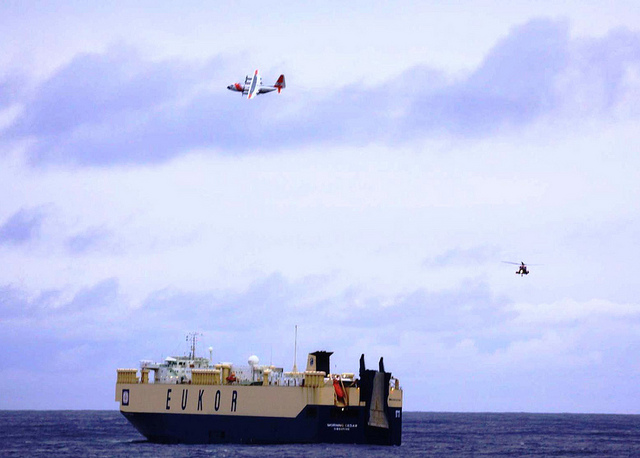

In [22]:
Image.open(img_name_val_keys[50])

In [23]:
image_path_to_caption_val[ img_name_val_keys[50] ]

['<start> A large large floating out in the water with an airplane flying over it. <end>',
 '<start> A boat is riding in the water while a helicopter is going by. <end>',
 '<start> A boat is sailing in the ocean and an airplane and helicopter are flying overhead. <end>',
 '<start> a helicopter and small plane fly through the air over the ocean and a large boat  <end>',
 '<start> a large boat with a plane flying above <end>']

In [24]:
val_img_to_cap_vector[ img_name_val_keys[50]  ]

[array([  3,   2,  12,   5, 132, 230, 440, 242,   5,   7,  25,   4,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([  3,  16, 112, 242, 561, 419,   2, 130,  10,   2, 132, 895,   5,
          2,  84,  25,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([   3,   94,  192,    1,    6, 1884,    5,    2,   25,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([  3,   2,  12

In [25]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(train_img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(train_img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(val_img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(val_img_to_cap_vector[imgv])

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(414113, 414113, 202654, 202654)

In [27]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 1024
#units = 512
units = 1024
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [28]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
from base_model import *

In [32]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
checkpoint_path = "./checkpoints/train_eng_v3"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [36]:
loss_plot = dict()
loss_plot['train'] = []
loss_plot['val'] = []

In [37]:
@tf.function
def train_val_step(img_tensor, target, val=False):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    if val:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
        
        total_loss = (loss / int(target.shape[1]))
        
        return loss, total_loss
    
            
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [46]:
def val_step_bleu(img_tensor):
    # img_tensor shape(batch_size, 299, 299, 3)
    batch = img_tensor.shape[0] # BATCH_SIZE//strategy.num_replicas_in_sync #
    hidden = decoder.reset_state(batch_size= batch)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch, 1)
    features = encoder(img_tensor)
  #   print(features.shape) # (BATCH_SIZE, IMG_FEAT_LEN, ENCODER_HID) = 64 100 256
    sequence_predictions = []
    for i in range(1, 47):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        # no teacher forcing
        dec_input, predicted_ids = pure_sampling_decoder(predictions)
        #dec_input, predicted_ids = top_k_sampling_decoder(predictions)
        #dec_input, predicted_ids = greedy_decoder(predictions)

        sequence_predictions.append(predicted_ids)

    sequence_predictions = tf.stack(sequence_predictions)
    sequence_predictions = tf.transpose(sequence_predictions)
    
    # return sequence_predictions in order to calculate bleu score
    return sequence_predictions 

In [38]:
def train_val(epoch, loss_plot, train_dataset, val_dataset):
    EPOCHS = epoch

    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (train_batch, (train_img_tensor, train_target)) in enumerate(train_dataset):

            train_batch_loss, t_loss = train_val_step(train_img_tensor, train_target)
            total_loss += t_loss

            if train_batch % 500 == 0:
                print ('\rEpoch {} Batch {} Train Loss {:.4f}'.format(
                  epoch + 1, train_batch, train_batch_loss.numpy() / int(train_target.shape[1])))
        
        # storing the epoch end loss value to plot later
        loss_plot['train'].append(total_loss / num_steps)

        
        
        # Do validation at the end of each epoch:
        # Take a subset of 200 batch validation dataset:
        sub_val_dataset = val_dataset.shuffle(200).take(200)
        
        total_val_loss = 0
        for (val_batch, (val_img_tensor, val_target)) in enumerate(sub_val_dataset):
            val_batch_loss, v_loss = train_val_step(val_img_tensor, val_target, val=True)
            total_val_loss += v_loss
            #print ('Epoch {} Val Batch {} Val Loss {:.4f}'.format(
            #      epoch + 1, val_batch, val_batch_loss.numpy() / int(val_target.shape[1])))

         # storing the epoch end loss value to plot later
        #num_val_steps = len(img_name_val) // 200
        loss_plot['val'].append(total_val_loss / 200)
        
        if epoch % 5 == 0:
            ckpt_manager.save()

        print('\rEpoch {} TrainLoss {:.6f} ValLoss {:.6f}'.format(epoch + 1,
                                             total_loss/num_steps, total_val_loss/200))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [39]:
train_val(epoch=21, loss_plot=loss_plot, train_dataset=train_dataset, val_dataset=val_dataset)

Epoch 3 Batch 0 Train Loss 0.6893
Epoch 3 Batch 500 Train Loss 0.5928
Epoch 3 Batch 1000 Train Loss 0.5168
Epoch 3 Batch 1500 Train Loss 0.5583
Epoch 3 Batch 2000 Train Loss 0.5233
Epoch 3 Batch 2500 Train Loss 0.5806
Epoch 3 Batch 3000 Train Loss 0.5668
Epoch 3 Batch 3500 Train Loss 0.5561
Epoch 3 Batch 4000 Train Loss 0.4699
Epoch 3 Batch 4500 Train Loss 0.4882
Epoch 3 Batch 5000 Train Loss 0.6041
Epoch 3 Batch 5500 Train Loss 0.5230
Epoch 3 Batch 6000 Train Loss 0.6326
Epoch 3 Batch 6500 Train Loss 0.5982
Epoch 3 Batch 7000 Train Loss 0.5103
Epoch 3 Batch 7500 Train Loss 0.4709
Epoch 3 Batch 8000 Train Loss 0.4950
Epoch 3 Batch 8500 Train Loss 0.4713
Epoch 3 Batch 9000 Train Loss 0.5302
Epoch 3 Batch 9500 Train Loss 0.6161
Epoch 3 Batch 10000 Train Loss 0.5249
Epoch 3 Batch 10500 Train Loss 0.4707
Epoch 3 Batch 11000 Train Loss 0.4776
Epoch 3 Batch 11500 Train Loss 0.6575
Epoch 3 Batch 12000 Train Loss 0.5778
Epoch 3 Batch 12500 Train Loss 0.6523
Epoch 3 TrainLoss 0.575026 ValLoss 0

KeyboardInterrupt: 

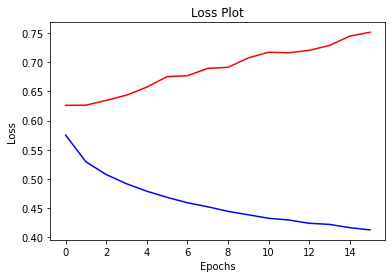

In [40]:
plt.plot(loss_plot['train'], 'b')
plt.plot(loss_plot['val'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [43]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

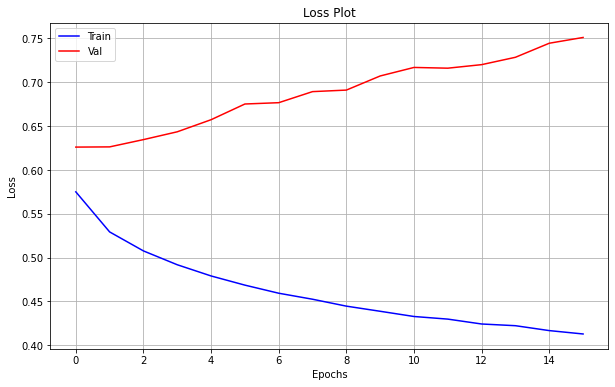

In [41]:
plt.figure(figsize=(10,6))
plt.plot(loss_plot['train'], 'b', label='Train')
plt.plot(loss_plot['val'], 'r', label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.grid(True)
plt.savefig('loss.png')
#plt.show()

In [42]:
# saving
with open('final_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
print('Calculating BLUE score')

Calculating BLUE score


In [45]:
import nltk